# Part1-Theory

### A)

**Convolutional Networks** use a regular grid for sampling input feature maps during the convolution operation. The sampling points are evenly distributed based on the filter size and stride, but **Deformable Convolutional Networks** use learned offsets to adjust the regular grid during the sampling process. The offsets are learned from the data, enabling the network to sample input features from locations that are more informative for the specific task.

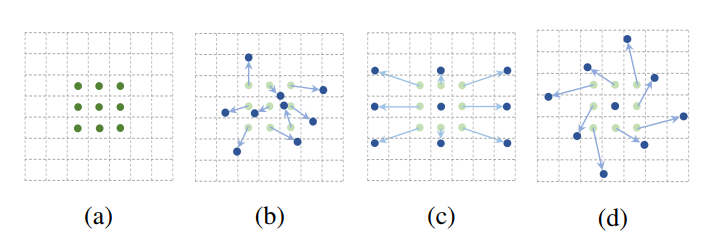
(a) regular sampling grid (green points) of standard convolution. (b) deformed sampling locations (dark blue points) with augmented offsets (light blue arrows) in deformable convolution.

As you see Traditional convolutional layers use fixed filters, where each filter has a fixed receptive field, and the same transformation is applied to all spatial locations within that field. Deformable convolutional layers use deformable convolutional kernels, allowing the network to adaptively adjust the receptive field for each spatial location. See following example from the article:

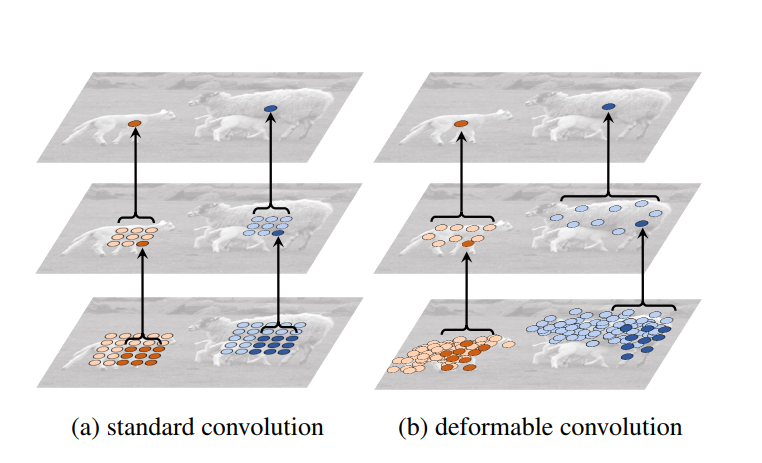

## B)

**DCNs** perform adaptive geometric transformations in images by learning spatial offsets for each location in the input feature map. This adaptability allows DCNs to adjust their convolutional kernels dynamically based on the content of the input image.

## C)

As I mentioned in the previous part, in ConvNets, each convolutional filter has a fixed receptive field. These fixed filters are designed to capture specific spatial patterns, and they might not adapt well to variations in rotation, scale, or orientation.

## D)

The deformable convolutional layer generates spatial offsets for each location in the input feature map. These offsets represent how much each location in the feature map should be shifted or deformed to better align with the features in the input image. The offsets are obtained by applying a convolutional layer over the same input feature map as you see in following figure.

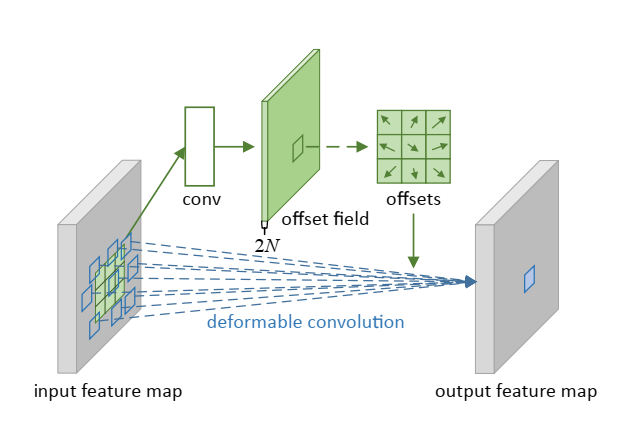

During training, both the convolutional kernels for generating the output features and the offsets are learned simultaneously via backpropagation.

# Part2-Practical

### Data Preparation

In [ ]:
# import libraries
import cv2
import os
import torch
import json
import random
import tqdm

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

Set seed for control the randomness and make a fair comparison between CNN and DCNN models.

In [ ]:
seed = 42
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True
    np.random.seed(seed)
    random.seed(seed)

setup_seed(seed)

#### Download COCO Dataset and exrtract labels from Json file

I used val2017 for training,validation, and test my models. This version of COCO consists of almost 5000 images and 90 classes.

In [ ]:
!wget 'http://images.cocodataset.org/zips/val2017.zip'
!unzip "/content/val2017.zip" -d "/content"
!wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
!unzip "/content/annotations_trainval2017.zip" -d "/content"


I load the 'instances_val2017.json' file with json.load function. coco_data is a dictionary which contains images IDs, category IDs and other information about the dataset.

Categories is a dictionary where keys are category IDs, and values are category names.

In [ ]:
# Load COCO annotation file
with open('annotations/instances_val2017.json', 'r') as f:
    coco_data = json.load(f)

# Extract category information
categories = {category['id']: category['name'] for category in coco_data['categories']}
print(categories)
print('Number of Classes:',len(coco_data['categories']))

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In following cell I created a maping between each image and its category IDs.
image_category_mapping is a dictionary where keys are image IDs, and values are lists of category IDs of each image.

In [ ]:
# Create a mapping between image IDs and category IDs
image_category_mapping = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']

    if image_id not in image_category_mapping:
        image_category_mapping[image_id] = []

    image_category_mapping[image_id].append(category_id)

#### Create Dataset class and Data loaders

In following cell a created CocoMultiLabelDataset. The Labels are multi-hot 90D vectors.I spilt the dataset (val2017) into train set (70%), validation set (15%), and test set (15%). Also I set batch size to 32. Number of batchs and images in each set are printed in next cell.

In [ ]:
# create custom dataset class
class CocoMultiLabelDataset(Dataset):
    def __init__(self, coco_data, image_dir, split='train', transform=None, train_size=0.70, val_size=0.15, test_size=0.15, random_seed=42):
        self.coco_data = coco_data
        self.image_dir = image_dir
        self.transform = transform

        # Create a mapping between image IDs and category IDs
        self.image_category_mapping = {}
        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            category_id = annotation['category_id']

            if image_id not in self.image_category_mapping:
                self.image_category_mapping[image_id] = []

            self.image_category_mapping[image_id].append(category_id)

        # List of image IDs
        self.image_ids = list(self.image_category_mapping.keys())

        # Split dataset into train, validation, and test sets
        train_ids, test_ids = train_test_split(self.image_ids, test_size=(val_size + test_size), random_state=random_seed)
        val_ids, test_ids = train_test_split(test_ids, test_size=test_size/(val_size + test_size), random_state=random_seed)

        if split == 'train':
            self.image_ids = train_ids
        elif split == 'val':
            self.image_ids = val_ids
        elif split == 'test':
            self.image_ids = test_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # create image path with image_id and zero padding to get a length of 12
        image_path = os.path.join(self.image_dir, f'{image_id:012d}.jpg')

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Get category IDs for the current image
        category_ids = self.image_category_mapping[image_id]

        # Convert category IDs to multi hot label tensor
        # category IDs' range is from 1 to 90 ( + 10)
        labels = torch.zeros(len(self.coco_data['categories'])+ 10)
        # subtract 1 from IDs to convert them to indexes
        labels[np.array(category_ids)-1] = 1

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, labels

# define a transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# set path to images
path = '/content/val2017'

# Cerate dataset objects
dataset_train = CocoMultiLabelDataset(coco_data, path, split='train', transform=transform)
dataset_val = CocoMultiLabelDataset(coco_data, path, split='val', transform=transform)
dataset_test = CocoMultiLabelDataset(coco_data, path, split='test', transform=transform)

# Create data loaders
batch_size = 32
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Print dataset sizes and batch sizes
print(f"Train set size: {dataset_train.__len__()}, Batch size: {batch_size}, Number of batches: {len(data_loader_train)}")
print(f"Validation set size: {dataset_val.__len__()}, Batch size: {batch_size}, Number of batches: {len(data_loader_val)}")
print(f"Test set size: {dataset_test.__len__()}, Batch size: {batch_size}, Number of batches: {len(data_loader_test)}")


Train set size: 3466, Batch size: 32, Number of batches: 109
Validation set size: 743, Batch size: 32, Number of batches: 24
Test set size: 743, Batch size: 32, Number of batches: 24


#### Show a batch of images with labels from training Dataloader

In next cell I implemeneted two functions. The multi_hot_to_category_ids function, takes a multi-hot vector and returns list of category IDs corresponding to hot indecies in the multi-hot vector. The second function, ids_to_category_names, takes a list of category IDs and return category names.

Finally In next cell I Showd a batch of training set with its categoy IDs and names.

Images shape: torch.Size([32, 3, 256, 256]), Labels shape: torch.Size([32, 90])


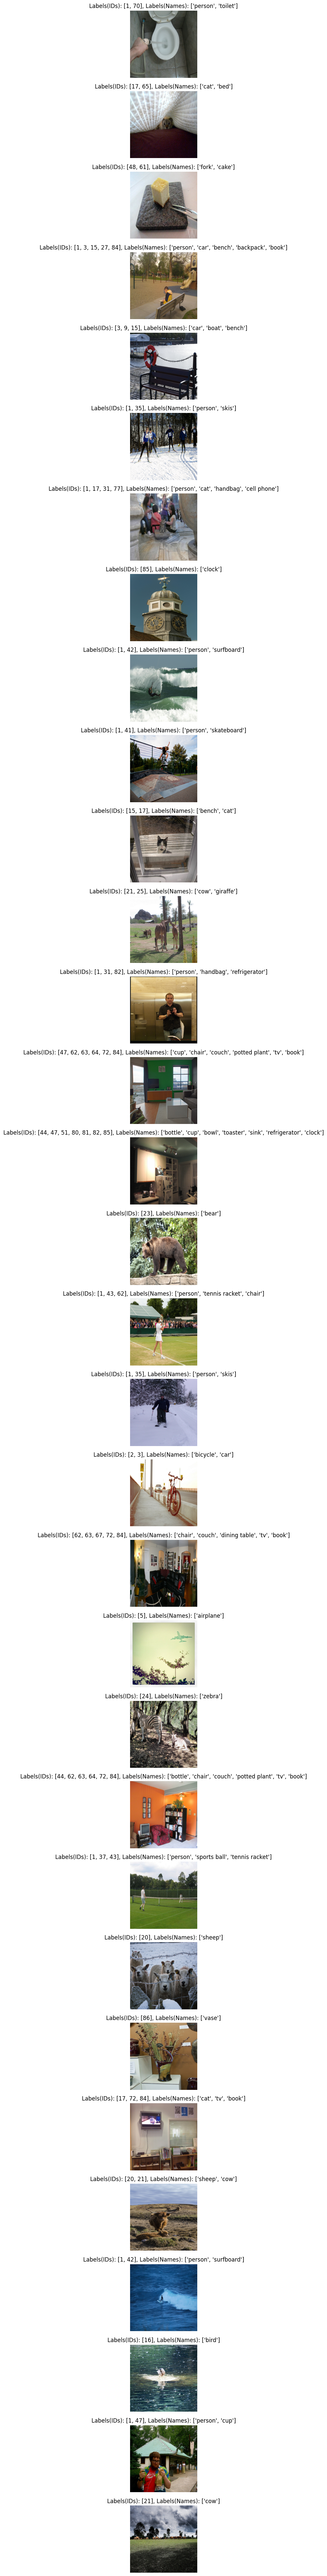

In [ ]:
# Function to get category ids from multi-hot vector
def multi_hot_to_category_ids(multi_hot_vector):
    # Get hot indexes
    nonzero_indexes = torch.nonzero(multi_hot_vector).flatten().tolist()
    # Add 1 to indexes to get ids
    ids = list(np.array(nonzero_indexes) + 1)
    return ids

# Function to get category names from a ids list
def ids_to_category_names(ids_list):
    category_names = [categories[id] for id in ids_list]
    return category_names



# Visualize a batch of training data
for images, labels in data_loader_train:

    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

    # Convert multi-hot vectors to category IDs
    category_ids_list = [multi_hot_to_category_ids(label) for label in labels]

    # Convert  category IDs to category names for visualization
    category_names_list = [ids_to_category_names(ids_list) for ids_list in category_ids_list]

    # Plot images and labels
    plt.figure(figsize=(100, 100))
    for i in range(images.shape[0]):
        plt.subplot(images.shape[0], 1, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(f"Labels(IDs): {category_ids_list[i]}, Labels(Names): {category_names_list[i]}")
        plt.axis('off')

    plt.show()

    # Show only the first batch
    break


### Design and Train a CNN model

#### Design a custom Architecture

In this part I implemented a CNN model. This model has four convolution blocks which each block consists of a 3x3 convolution filter with stride=1 and padding=1, Relu as an activation function and a maxpooling 2x2 with stride=2.
First block has 64 filters, the second one has 128 filters, the third one has 256 filters, and finally the forth one has 512 filters.
After these Four Conve blocks, there are two convolution blocks. Each of them has 512 conve filters that followed by a Relu activation function. Finally Before FC layer I used a global average pooling layer. The FC network has a hidden layer with 1024 neurons and Relu activation function. In output layer with 90 neurons, I used Sigmoid because the task is a multi label classification with 90 classes.

The Architecture of the model is printed below.

In [ ]:
class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(512,1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Dropout layer to prevent overfitting,I did not use in finall model.(p=1)
        self.dropout = nn.Dropout(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flatten the output for fully connected layers
        x = x.view(-1, 512)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Sigmoid activation for multi-label classification
        return torch.sigmoid(x)

# Instantiate the model
num_classes = 90
model = MultiLabelCNN(num_classes)

# Print the model architecture
print(model)

MultiLabelCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=90, bias=True)
  (dropout): Dropout(p=1, inplace=False)
)


#### Metrics Calculations

For calculating metrics first of all, I converted the predictions and labels to numpy array with  'prepare_for_conf' function and then calculate Confusion matrices for each class by 'multilabel_confusion_matrix' function from sklearn.
Then I aggregated the matrices and calculate Accuracy, F1, Recall, and Precision scores. Acctually I used Macro Averaging method for aggregation.

In [ ]:
# convert tensors to numpy array and
# convert them to a (number of preds, number of class) matrix
def prepare_for_conf(data_laoder, batch_size, tensor_conf):
    number_of_batches = len(data_laoder)
    out_list = []
    for i in range(number_of_batches):
      if i != number_of_batches - 1:
          for j in range(batch_size):
            out_list.append(np.array(tensor_conf[i].cpu())[j])
      else:
          for j in range(len(tensor_conf[i])):
            out_list.append(np.array(tensor_conf[i].cpu())[j])
    return np.array(out_list)


# this function calculate the model metrics by macro averaging method
def calculate_metrics(data_loader, batch_size, tensor_labels,  tensor_preds):

    # create y_true and y_pred for cinfusion matrix calculation
    y_true = prepare_for_conf(data_loader, batch_size, tensor_labels)
    y_pred = prepare_for_conf(data_loader, batch_size, tensor_preds)

    # Calculate confusion matrix
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

    # Sum all confusion matrices
    aggregated_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # get TP, FP, FN, TN for calculating metrics
    TP, FP, FN, TN = aggregated_confusion_matrix.ravel()
    Accuracy = (TP + TN)/(TP + FP + FN + TN)
    Recall = TP/(TP + FN)
    Precision = TP/(TP + FP)
    F1 = 2*(Precision * Recall)/(Precision + Recall)

    return Accuracy, Recall, Precision, F1

#### Train, Validation, and Test

In this part I define two functions. Train function for training the models which takes model, data loaders, loss function, optimizer, and number of epochs. The function prints the model performance in each epoch. The second function is evaluate function for performing validation in each epoch to check the model fitting.

In [ ]:
# Training loop
def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        train_preds_conf = []
        train_labels_conf = []

        for inputs, labels in tqdm.tqdm(train_dataloader):
            # Assuming your model takes a pair of images as input
            outputs = model(inputs.to(device))
            labels = labels.to(device)

            # Convert labels to float
            labels = labels.float()

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update statistics
            running_loss += loss.item()
            total_samples += labels.size(0)

            train_labels_conf.append(labels)
            train_preds_conf.append((outputs > 0.5).float())

            total_correct += ((outputs > 0.5).float() == labels).sum().item()

        # Calculate training  matrics and losse
        accuracy_train, recall_train, precision_train, F1_train = calculate_metrics(train_dataloader, batch_size, train_labels_conf, train_preds_conf)

        avg_loss = running_loss / len(train_dataloader)

        # Validation
        val_loss, accuracy_val, recall_val, precision_val, F1_val = evaluate(model, val_dataloader, criterion)

        # save_path = f'model_epoch_{epoch+1}.pth'
        # Save the entire model
        # torch.save(model, save_path)

        # save for plot
        Loss_train.append(avg_loss)
        Loss_val.append(val_loss)
        acc_train.append(accuracy_train)
        acc_val.append(accuracy_val)

        print(f'Epoch [{epoch+1}/{epochs}]: '
              f'Training Loss: {avg_loss:.4f}, '
              f'Training Accuracy: {accuracy_train*100:.2f} %, '
              f'Training F1: {F1_train*100:.2f} %, '
              f'Training Precision: {precision_train*100:.2f} %, '
              f'Training Recall: {recall_train*100:.2f} %, ||'
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {accuracy_val*100:.2f} %,'
              f'Validation F1: {F1_val*100:.2f} %,'
              f'Validation Precision: {precision_val*100:.2f} %,'
              f'Validation Recall: {recall_val*100:.2f} %,'
              )

import torch
import torchvision.ops
from torch import nn

def evaluate(model, dataloader, criterion):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    val_preds_conf = []
    val_labels_conf = []

    with torch.no_grad():
        for inputs, labels in dataloader:

            outputs = model(inputs.to(device))
            labels = labels.to(device)

            # Convert labels to float
            labels = labels.float()

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update statistics

            val_labels_conf.append(labels)
            val_preds_conf.append((outputs > 0.5).float())

            running_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += ((outputs > 0.5).float() == labels).sum().item()

    # Calculate validation  matrics and losse
    accuracy_val, recall_val, precision_val, F1_val = calculate_metrics(
            dataloader, batch_size, val_labels_conf, val_preds_conf)

    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy_val, recall_val, precision_val, F1_val

Below function is for test the model and printing the model results in with unseen data.

In [ ]:
def test(model, dataloader, criterion):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    test_preds_conf = []
    test_labels_conf = []

    with torch.no_grad():
        for inputs, labels in dataloader:

            outputs = model(inputs.to(device))
            labels = labels.to(device)

            # Convert labels to float
            labels = labels.float()

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update statistics

            test_labels_conf.append(labels)
            test_preds_conf.append((outputs > 0.5).float())

            running_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += ((outputs > 0.5).float() == labels).sum().item()

    # Calculate test metrcis and average loss
    accuracy_test, recall_test, precision_test, F1_test = calculate_metrics(
            dataloader, batch_size, test_labels_conf, test_preds_conf)

    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy_test, recall_test, precision_test, F1_test

Below code sets device to 'cuda' and then creates an instance of the model. I used SGD optimizer with lr=0.001.

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = MultiLabelCNN(90).to(device)
citeration = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

The Model is trained with 10 epochs

In [ ]:
# Train the model
Loss_train=[]
Loss_val=[]

acc_train = []
acc_val = []

epochs = 10
train(model, data_loader_train, data_loader_val, citeration, optimizer, epochs=epochs)

100%|██████████| 109/109 [00:43<00:00,  2.52it/s]


Epoch [1/10]: Training Loss: 0.6926, Training Accuracy: 53.56 %, Training F1: 69.06 %, Training Precision: 53.56 %, Training Recall: 97.17 %, ||Validation Loss: 0.6928, Validation Accuracy: 48.58 %,Validation F1: 64.43 %,Validation Precision: 48.15 %,Validation Recall: 97.33 %,


100%|██████████| 109/109 [00:43<00:00,  2.52it/s]


Epoch [2/10]: Training Loss: 0.6924, Training Accuracy: 53.56 %, Training F1: 69.06 %, Training Precision: 53.56 %, Training Recall: 97.17 %, ||Validation Loss: 0.6925, Validation Accuracy: 50.25 %,Validation F1: 66.01 %,Validation Precision: 49.95 %,Validation Recall: 97.30 %,


100%|██████████| 109/109 [00:46<00:00,  2.35it/s]


Epoch [3/10]: Training Loss: 0.6921, Training Accuracy: 53.56 %, Training F1: 69.06 %, Training Precision: 53.56 %, Training Recall: 97.17 %, ||Validation Loss: 0.6922, Validation Accuracy: 50.57 %,Validation F1: 66.31 %,Validation Precision: 50.30 %,Validation Recall: 97.29 %,


100%|██████████| 109/109 [00:55<00:00,  1.98it/s]


Epoch [4/10]: Training Loss: 0.6918, Training Accuracy: 54.19 %, Training F1: 69.63 %, Training Precision: 54.27 %, Training Recall: 97.10 %, ||Validation Loss: 0.6920, Validation Accuracy: 50.95 %,Validation F1: 66.66 %,Validation Precision: 50.69 %,Validation Recall: 97.28 %,


100%|██████████| 109/109 [00:45<00:00,  2.39it/s]


Epoch [5/10]: Training Loss: 0.6916, Training Accuracy: 54.56 %, Training F1: 69.96 %, Training Precision: 54.69 %, Training Recall: 97.07 %, ||Validation Loss: 0.6917, Validation Accuracy: 52.83 %,Validation F1: 68.36 %,Validation Precision: 52.68 %,Validation Recall: 97.32 %,


100%|██████████| 109/109 [00:44<00:00,  2.44it/s]


Epoch [6/10]: Training Loss: 0.6913, Training Accuracy: 55.62 %, Training F1: 70.87 %, Training Precision: 55.81 %, Training Recall: 97.08 %, ||Validation Loss: 0.6914, Validation Accuracy: 54.80 %,Validation F1: 70.09 %,Validation Precision: 54.75 %,Validation Recall: 97.36 %,


100%|██████████| 109/109 [00:47<00:00,  2.30it/s]


Epoch [7/10]: Training Loss: 0.6910, Training Accuracy: 56.62 %, Training F1: 71.72 %, Training Precision: 56.86 %, Training Recall: 97.09 %, ||Validation Loss: 0.6912, Validation Accuracy: 55.88 %,Validation F1: 71.03 %,Validation Precision: 55.91 %,Validation Recall: 97.34 %,


100%|██████████| 109/109 [00:55<00:00,  1.95it/s]


Epoch [8/10]: Training Loss: 0.6908, Training Accuracy: 56.62 %, Training F1: 71.72 %, Training Precision: 56.86 %, Training Recall: 97.09 %, ||Validation Loss: 0.6909, Validation Accuracy: 55.95 %,Validation F1: 71.09 %,Validation Precision: 55.99 %,Validation Recall: 97.33 %,


100%|██████████| 109/109 [00:43<00:00,  2.50it/s]


Epoch [9/10]: Training Loss: 0.6905, Training Accuracy: 57.62 %, Training F1: 72.57 %, Training Precision: 57.94 %, Training Recall: 97.08 %, ||Validation Loss: 0.6906, Validation Accuracy: 57.20 %,Validation F1: 72.19 %,Validation Precision: 57.44 %,Validation Recall: 97.15 %,


100%|██████████| 109/109 [00:42<00:00,  2.54it/s]


Epoch [10/10]: Training Loss: 0.6902, Training Accuracy: 57.65 %, Training F1: 72.60 %, Training Precision: 57.97 %, Training Recall: 97.08 %, ||Validation Loss: 0.6904, Validation Accuracy: 57.90 %,Validation F1: 72.79 %,Validation Precision: 58.24 %,Validation Recall: 97.05 %,


Test the model.

In [ ]:
test_loss, accuracy_test, recall_test, precision_test, F1_test = test(model, data_loader_test, citeration)
print(f' Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy_test*100:.2f}% , Test F1: {F1_test*100:.2f}% , Test Precision: {precision_test*100:.2f}% , Test Recall: {recall_test*100:.2f}%')

 Test Loss: 0.6904, Test Accuracy: 57.84% , Test F1: 72.73% , Test Precision: 58.23% , Test Recall: 96.85%


#### Plot Results

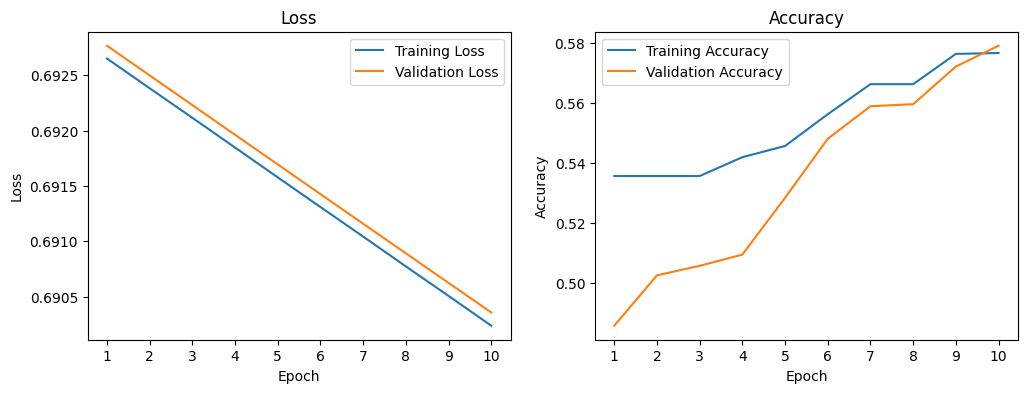

In [ ]:
x_axis =[i for i in range(1, epochs+1)]
plt.figure(figsize=(12, 4))
# Plotting Loss
plt.subplot(1, 2, 1)
plt.xticks(x_axis, x_axis)
plt.plot(x_axis, Loss_train, label='Training Loss')
plt.plot(x_axis, Loss_val, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.xticks(x_axis, x_axis)
plt.plot(x_axis, acc_train, label='Training Accuracy')
plt.plot(x_axis, acc_val, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Design and Train a Deformable CNN model

#### Implement DeformableConve2d Class

In this part I implemented DeformableConv2d class. First of all I calculate the offsets by performing a regular convolution and then apply the convolutin with calculated offsets.The default kernel size is set to 3x3.

In [ ]:
class DeformableConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
        bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding

        self.offset_conv = nn.Conv2d(
            in_channels, 2 * kernel_size * kernel_size, kernel_size=kernel_size,
            stride=stride, padding=self.padding, bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(
            in_channels, 1 * kernel_size * kernel_size, kernel_size=kernel_size,
            stride=stride, padding=self.padding, bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=stride, padding=self.padding,
            bias=bias)

    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.
        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        x = torchvision.ops.deform_conv2d(
            input=x, offset=offset, weight=self.regular_conv.weight,
            bias=self.regular_conv.bias, padding=self.padding, mask=modulator)

        return x

#### Modify the CNN model and add Deformable blocks

In this section I implemented my DCNN model. The archtecture of the model is as same as CNN model, but I use tow Deformable blocks in last tow conv layers. (5th and 6th layers). Rest of the architecture like number of filters, strides, and paddings are like the CNN model.

The architecture of the model is printed below.

In [ ]:
class MultiLabelDCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelDCNN, self).__init__()

        # Convolutional & Deformable Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = DeformableConv2d(512, 512, kernel_size=3, padding=1)
        self.conv6 = DeformableConv2d(512, 512, kernel_size=3, padding=1)


        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(512,1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flatten the output for fully connected layers
        x = x.view(-1, 512)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Sigmoid activation for multi-label classification
        return torch.sigmoid(x)

# Instantiate the model
num_classes = 90  # Change this to the number of classes in your dataset
deformable_model = MultiLabelDCNN(num_classes)

# Print the model architecture
print(deformable_model)

MultiLabelDCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): DeformableConv2d(
    (offset_conv): Conv2d(512, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(512, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv6): DeformableConv2d(
    (offset_conv): Conv2d(512, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(512, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, di

#### Train, Validation, and Test

Below code sets device to 'cuda' and then creates an instance of the model. I used SGD optimizer with lr=0.001.

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

deformable_model = MultiLabelDCNN(90).to(device)
citeration_deform = nn.BCELoss()

optimizer_deform= torch.optim.SGD(deformable_model.parameters(), lr=0.001)

Model is trained with 10 epochs

In [ ]:
Loss_train = []
Loss_val = []
acc_train = []
acc_val = []

# Train the deformable_model
epochs = 10
train(deformable_model, data_loader_train, data_loader_val, citeration_deform, optimizer_deform, epochs=epochs)

100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [1/10]: Training Loss: 0.6921, Training Accuracy: 57.49 %, Training F1: 72.65 %, Training Precision: 58.37 %, Training Recall: 96.20 %, ||Validation Loss: 0.6909, Validation Accuracy: 59.76 %,Validation F1: 74.32 %,Validation Precision: 60.21 %,Validation Recall: 97.06 %,


100%|██████████| 109/109 [00:59<00:00,  1.82it/s]


Epoch [2/10]: Training Loss: 0.6918, Training Accuracy: 58.58 %, Training F1: 73.54 %, Training Precision: 59.50 %, Training Recall: 96.25 %, ||Validation Loss: 0.6907, Validation Accuracy: 60.77 %,Validation F1: 75.14 %,Validation Precision: 61.30 %,Validation Recall: 97.05 %,


100%|██████████| 109/109 [00:52<00:00,  2.06it/s]


Epoch [3/10]: Training Loss: 0.6916, Training Accuracy: 58.76 %, Training F1: 73.69 %, Training Precision: 59.69 %, Training Recall: 96.26 %, ||Validation Loss: 0.6904, Validation Accuracy: 61.88 %,Validation F1: 76.02 %,Validation Precision: 62.46 %,Validation Recall: 97.09 %,


100%|██████████| 109/109 [00:53<00:00,  2.02it/s]


Epoch [4/10]: Training Loss: 0.6913, Training Accuracy: 58.76 %, Training F1: 73.69 %, Training Precision: 59.69 %, Training Recall: 96.26 %, ||Validation Loss: 0.6901, Validation Accuracy: 63.00 %,Validation F1: 76.88 %,Validation Precision: 63.61 %,Validation Recall: 97.14 %,


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [5/10]: Training Loss: 0.6910, Training Accuracy: 58.83 %, Training F1: 73.75 %, Training Precision: 59.77 %, Training Recall: 96.26 %, ||Validation Loss: 0.6899, Validation Accuracy: 63.00 %,Validation F1: 76.88 %,Validation Precision: 63.61 %,Validation Recall: 97.14 %,


100%|██████████| 109/109 [00:52<00:00,  2.06it/s]


Epoch [6/10]: Training Loss: 0.6908, Training Accuracy: 59.76 %, Training F1: 74.51 %, Training Precision: 60.79 %, Training Recall: 96.24 %, ||Validation Loss: 0.6896, Validation Accuracy: 63.00 %,Validation F1: 76.88 %,Validation Precision: 63.61 %,Validation Recall: 97.14 %,


100%|██████████| 109/109 [00:51<00:00,  2.10it/s]


Epoch [7/10]: Training Loss: 0.6905, Training Accuracy: 59.76 %, Training F1: 74.51 %, Training Precision: 60.79 %, Training Recall: 96.24 %, ||Validation Loss: 0.6893, Validation Accuracy: 64.01 %,Validation F1: 77.67 %,Validation Precision: 64.70 %,Validation Recall: 97.13 %,


100%|██████████| 109/109 [00:59<00:00,  1.84it/s]


Epoch [8/10]: Training Loss: 0.6902, Training Accuracy: 60.58 %, Training F1: 75.18 %, Training Precision: 61.72 %, Training Recall: 96.17 %, ||Validation Loss: 0.6891, Validation Accuracy: 64.03 %,Validation F1: 77.68 %,Validation Precision: 64.72 %,Validation Recall: 97.13 %,


100%|██████████| 109/109 [01:01<00:00,  1.78it/s]


Epoch [9/10]: Training Loss: 0.6900, Training Accuracy: 63.18 %, Training F1: 77.24 %, Training Precision: 64.57 %, Training Recall: 96.09 %, ||Validation Loss: 0.6888, Validation Accuracy: 66.10 %,Validation F1: 79.25 %,Validation Precision: 66.94 %,Validation Recall: 97.11 %,


100%|██████████| 109/109 [00:52<00:00,  2.09it/s]


Epoch [10/10]: Training Loss: 0.6897, Training Accuracy: 63.70 %, Training F1: 77.64 %, Training Precision: 65.12 %, Training Recall: 96.11 %, ||Validation Loss: 0.6885, Validation Accuracy: 66.10 %,Validation F1: 79.25 %,Validation Precision: 66.94 %,Validation Recall: 97.11 %,


In [ ]:
test_loss, accuracy_test, recall_test, precision_test, F1_test = test(
    deformable_model, data_loader_test, citeration_deform)

print(f' Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy_test*100:.2f}% , Test F1: {F1_test*100:.2f}% , Test Precision: {precision_test*100:.2f}% , Test Recall: {recall_test*100:.2f}%')

 Test Loss: 0.6885, Test Accuracy: 65.89% , Test F1: 79.10% , Test Precision: 66.86% , Test Recall: 96.83%


#### Plot Results

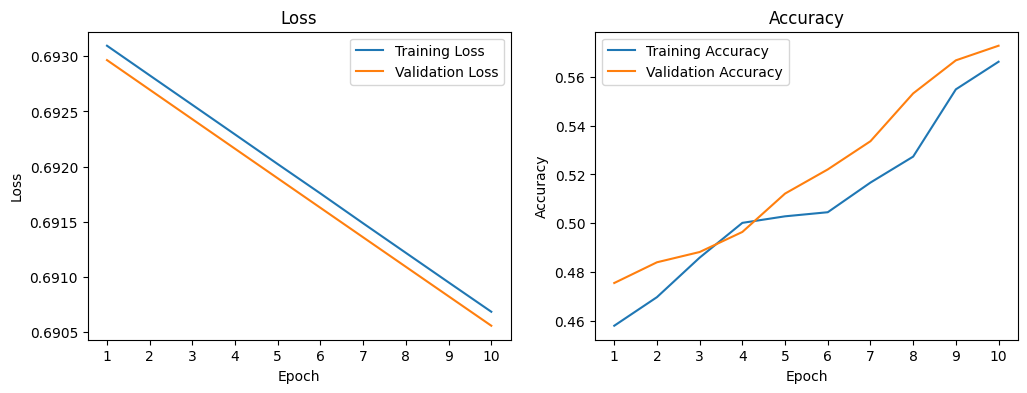

In [ ]:
x_axis =[i for i in range(1, epochs+1)]
plt.figure(figsize=(12, 4))
# Plotting Loss
plt.subplot(1, 2, 1)
plt.xticks(x_axis, x_axis)
plt.plot(x_axis, Loss_train, label='Training Loss')
plt.plot(x_axis, Loss_val, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.xticks(x_axis, x_axis)
plt.plot(x_axis, acc_train, label='Training Accuracy')
plt.plot(x_axis, acc_val, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###  Report and Compare The Models Performance

**I explained Each part of my code completely at above of each cell, this part is for summary and conclusion.**

Lets compare the models and make a conclusion. First of all the location of the deformable blocks are very impotant and I performed several experiments to find these facts (It takes a DAY!! even more). I use SGD with lr=000.1 and 5 epochs for following experiments.




1- In the first one I use Deformable blocks in last two convolution layers and train the model with 5 epochs, here is the result,I got max train accuracy 61.06% and test accuracy 54.62%.


2- In the second one I use Deformable blocks in first two convolution layers and train the model with 5 epochs, here is the result,I got max train accuracy 46% and test accuracy 44.63%. I know this is awful.



3- Finally in the last experiment I use Deformable blocks in two middle convolution layers and train the model with 5 epochs, here is the result,I got max train accuracy 55.25% and test accuracy 53.65% .


**So far I found I shuold not use Deformabel blocks in early layer and one of the important points is if we use Pooling layers between Deformable blocks the performance will be worse than without Pooling layers.**

As you saw in prevoius parts of my code Finally I used below architecture for my CNN model.

MultiLabelCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))



  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)


  (fc1): Linear(in_features=512, out_features=1024, bias=True)


  (fc2): Linear(in_features=1024, out_features=90, bias=True)
)

And I used below architecture for my DCNN model.

MultiLabelDCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


  (conv5): DeformableConv2d(
    (offset_conv): Conv2d(512, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(512, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )


  (conv6): DeformableConv2d(
    (offset_conv): Conv2d(512, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(512, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )


  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)


  (fc1): Linear(in_features=512, out_features=1024, bias=True)


  (fc2): Linear(in_features=1024, out_features=90, bias=True)
)

**Finally I trained two models with the mentioned architecture. I set all of the veriabels and states same. I use 'setup_seed' function for set the random state same for all parts of my code to make a fair comparison between models. I used SGD with lr=0.001 and trained both model 10 epochs. The results are here:**

**In CNN model I got Train Accuracy 57.65 %, Validation Accuracy 57.90 %, and Test Accuracy 57.84 %. Each epoch take around 50 seconds**


**In DCNN model I got Train Accuracy 63.70 %, Validation Accuracy 66.10 %, and Test Accuracy 65.89 %. Each epoch take around 1 minute.**


**The last word is that DCNN takes more training time due to offset calculations, but its performance is much better than that of regular CNN models, achieving an 8% improvement in this experiment based on the accuracy metric. You can review other metrics in the output of the training and test cells .**

**THE END**



**Also I performed this Experiment on MNIST Dataset.The related notebook is available in the repository.**

**Summary:**

**CNN Model Accuracy : 90.03 %**

**DCNN Model Accuracy : 92.90 %**